In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBClassifier

In [5]:
from yahooquery import Ticker
#import pandas as pd

ticker = "PETR4.SA"

petr = Ticker(ticker)
df = petr.history(period='60d',  interval = "5m")
df.reset_index(inplace=True)
df.to_csv(r'..\ml-financial-market\data\raw\raw.csv')

In [40]:
data = pd.read_csv(r'..\ml-financial-market\data\raw\raw.csv')

df = data[['close', 'volume']]


def column_shifter(n_shift, df, column):
    for i in range(1, n_shift):
        df[f'{column}_minus{i}'] = df[column].shift(i)

for column in ['close', 'volume']:
    column_shifter(28, df, column)

df.dropna(inplace=True) 

In [41]:
df['Rise'] = 1
periods_ahead = 24
positive_variation = 1.02

for i in range(0,len(df)-periods_ahead):
    for j in range(1,periods_ahead):
        if df['close'].iloc[i]/df['close'].iloc[i+j] > positive_variation:
            df['Rise'].iloc[i] = 1
            break
        else:
            df['Rise'].iloc[i] = 0

df = df.iloc[:-periods_ahead]

In [42]:
# Splitting into subsets
X = df.drop('Rise', axis=1)
y = df['Rise']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1949)

# Scaling data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
X_train[0].shape

(56,)

In [67]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


df = pd.read_csv(r'..\ml-financial-market\data\interim\interim.csv')

X = df.drop('Rise', axis=1)
y = df['Rise']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1949)

# Scaling data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# pd.Series(X_train).to_csv(r'..\ml-financial-market\data\processed\X_train.csv')
# pd.Series(X_test).to_csv(r'..\ml-financial-market\data\processed\X_test.csv')

In [68]:
X_train.shape

(3235, 57)

In [53]:

for df in ['X_train', 'X_test', 'y_train', 'y_test']:
    df = pd.read_csv(fr'..\ml-financial-market\data\processed\{df}.csv')
    df = np.array(df)

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

X_train = np.array(pd.read_csv(r'..\ml-financial-market\data\processed\X_train.csv'))
y_train = pd.read_csv(r'..\ml-financial-market\data\processed\y_train.csv')

early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

# Building the model
model = Sequential()
model.add(Dense(units=28,activation='relu'))
model.add(Dense(units=14,activation='relu'))
model.add(Dense(units=7,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])


# Fitting the model
model.fit(x=X_train, 
        y=y_train.values,
        epochs=1, verbose=0.1,
        validation_data=(X_train,y_train.values),
        callbacks=[early_stop])

In [81]:
model.history.history

{'loss': [0.30375102162361145],
 'accuracy': [0.936321496963501],
 'val_loss': [0.24899503588676453],
 'val_accuracy': [0.9366306066513062]}

In [70]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras

model = keras.models.load_model(r'..\ml-financial-market\models')

# X_test = pd.read_csv(r'..\ml-financial-market\data\processed\X_test.csv')
# y_test = pd.read_csv(r'..\ml-financial-market\data\processed\y_test.csv')

# # Getting loss and accuracy plot
# model_loss = pd.DataFrame(model.history.history)
# model_loss.plot()

# # Getting predictions metrics
# predictions = model.predict_classes(X_test)
# print(classification_report(y_test,predictions))
# print(confusion_matrix(y_test,predictions))

In [77]:
model.history

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1280
           1       0.00      0.00      0.00       107

    accuracy                           0.92      1387
   macro avg       0.46      0.50      0.48      1387
weighted avg       0.85      0.92      0.89      1387

[[1280    0]
 [ 107    0]]


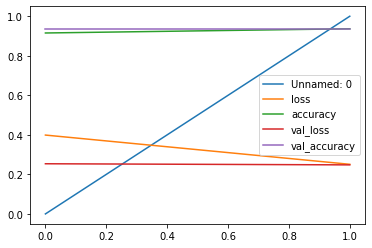

In [82]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from tensorflow import keras

model = keras.models.load_model(r'..\ml-financial-market\models')
model_history = pd.read_csv(r'..\ml-financial-market\models\\history.csv')

X_test = pd.read_csv(r'..\ml-financial-market\data\processed\X_test.csv')
y_test = pd.read_csv(r'..\ml-financial-market\data\processed\y_test.csv')


# Getting loss and accuracy plot
model_loss = pd.DataFrame(model_history)
model_loss.plot()

# Getting predictions metrics
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

# GRID SEARCH - ANN

In [45]:
def model_ann(units, units_decrease):
  # Creating Early Stop callback
  early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

  # Building the model
  model = Sequential()
  model.add(Dense(units=units,activation='relu'))
  units = round(units * units_decrease)
  model.add(Dense(units=units,activation='relu'))
  units = round(units * units_decrease)
  model.add(Dense(units=units,activation='relu'))
  units = round(units * units_decrease)
  model.add(Dense(units=units,activation='relu'))
  model.add(Dense(units=1,activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
              metrics=['accuracy'])


  # Fitting the model
  model.fit(x=X_train, 
            y=y_train.values,
            epochs=2000, verbose=0,
          validation_data=(X_train,y_train.values),
          callbacks=[early_stop])
  
  # Getting loss and accuracy plot
  losses = pd.DataFrame(model.history.history)
  

  # Getting predictions metrics
  predictions = model.predict_classes(X_test)
  report = classification_report(y_test,predictions)
  confusion = confusion_matrix(y_test,predictions)
  tp_fp = confusion_matrix(y_test,predictions)[1][1]/confusion_matrix(y_test,predictions)[0][1]
  
  # Returns prediction RMSE (Root Mean Square Error)
  return report, confusion, losses, tp_fp

In [46]:
# GRIDSEARCH
# Hyperparameters List

units_list = [25, 50, 70]
interval_list = [0.9, 0.8, 0.7]

# Initialising grid dictionaries
grid_report = {}
grid_losses = {}
grid_tp_fp = {}
grid_confusion = {}

nr_of_models = str(len(units_list)*len(interval_list))
print(nr_of_models)

# Running the models
for unit in units_list:
  for interval in interval_list:
      # Fetching results from the model
      report, confusion, losses, tp_fp = model_ann(unit, interval)
      
      # Adding results to the dictionaries
      current_model = '{} units, {} decresease_interval, {} epochs'.format(unit,interval, len(losses))
      grid_report[current_model] = report
      grid_confusion[current_model] = confusion
      grid_losses[current_model] = losses
      grid_tp_fp[current_model] = tp_fp


      print(str(len(grid_report.items())), end=', ')
      print(tp_fp)

9
Epoch 00317: early stopping
1, 2.25
Epoch 00254: early stopping
2, 1.4
Epoch 00449: early stopping
3, 0.875
Epoch 00261: early stopping
4, 0.875
Epoch 00382: early stopping
5, 2.1666666666666665
Epoch 00652: early stopping
6, 1.5384615384615385
Epoch 00320: early stopping
7, 9.0
Epoch 00335: early stopping
8, 1.5833333333333333
Epoch 00416: early stopping
9, 1.0


In [47]:
grid_tp = pd.DataFrame.from_dict(grid_tp_fp.items())
print(grid_tp.sort_values(by=1, ascending=False).head(10))
best_model = pd.DataFrame(grid_tp.sort_values(by=1, ascending=False).iloc[:,0]).reset_index()[0][0]
print('\n')
print('Best model: '+best_model)
print('\n')
print(grid_report[best_model])
print(grid_confusion[best_model])

                                               0         1
6  70 units, 0.9 decresease_interval, 320 epochs  9.000000
0  25 units, 0.9 decresease_interval, 317 epochs  2.250000
4  50 units, 0.8 decresease_interval, 382 epochs  2.166667
7  70 units, 0.8 decresease_interval, 335 epochs  1.583333
5  50 units, 0.7 decresease_interval, 652 epochs  1.538462
1  25 units, 0.8 decresease_interval, 254 epochs  1.400000
8  70 units, 0.7 decresease_interval, 416 epochs  1.000000
2  25 units, 0.7 decresease_interval, 449 epochs  0.875000
3  50 units, 0.9 decresease_interval, 261 epochs  0.875000


Best model: 70 units, 0.9 decresease_interval, 320 epochs


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1280
           1       0.90      0.08      0.15       107

    accuracy                           0.93      1387
   macro avg       0.91      0.54      0.56      1387
weighted avg       0.93      0.93      0.90      1387

[[1279    1]
 [  98  

# XGBOOST

In [23]:
classifier = XGBClassifier(eta= 0.6 , gamma=0.1 , alpha=0.1 , reg_lambda=0.5 )
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
TP_FP_ratio = confusion_matrix(y_test,y_pred)[1][1]/confusion_matrix(y_test,y_pred)[0][1]
print(TP_FP_ratio)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1343
           1       1.00      0.04      0.08        72

    accuracy                           0.95      1415
   macro avg       0.98      0.52      0.53      1415
weighted avg       0.95      0.95      0.93      1415

[[1343    0]
 [  69    3]]
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [24]:
def model_xgboost(gamma, eta, alpha, reg_lambda):
    # Fitting XGBoost to the Training set
    classifier = XGBClassifier(gamma=gamma, eta=eta, alpha=alpha, reg_lambda=reg_lambda)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    # Making the Confusion Matrix
    class_report = classification_report(y_test,y_pred)
    confusion = confusion_matrix(y_test,y_pred)
    TP_FP_ratio = confusion_matrix(y_test,y_pred)[1][1]/confusion_matrix(y_test,y_pred)[0][1]
    return class_report, confusion, TP_FP_ratio

In [25]:
eta_list = [0.2, 0.3, 0.4, 0.5 , 0.6, 0.7]
gamma_list = [0.1, 0.3, 0.5]
alpha_list = [0.1, 0.5]
lambda_list = [0.1, 0.5]


# Initialising grid dictionaries
grid_report = {}
grid_confusion = {}
grid_tp_fp = {}

nr_of_models = str(len(eta_list)*len(gamma_list)*len(alpha_list)*len(lambda_list))
print(nr_of_models)

# Running the models
for eta in eta_list:
  for gamma in gamma_list:
    for alpha in alpha_list:
      for lambda_ in lambda_list:
      # Fetching results from the model
        model_report, model_confusion, model_tp_fp = model_xgboost(eta, gamma, alpha, lambda_)
        
        # Adding results to athe dictionaries
        current_model = '{} eta, {} gamma, {} alpha, {} lambda'.format(eta, gamma, alpha, lambda_)
        grid_report[current_model] = model_report
        grid_confusion[current_model] = model_confusion
        grid_tp_fp[current_model] = model_tp_fp
        print(str(len(grid_report.items())), end=', ')

72


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 

In [26]:
grid_tp = pd.DataFrame.from_dict(grid_tp_fp.items())
print(grid_tp.sort_values(by=1, ascending=False).head(10))
best_model = grid_tp.sort_values(by=1, ascending=False).iloc[:,0][0]
print('\n')
print('Best model: '+best_model)
print('\n')
print(grid_report[best_model])
print(grid_confusion[best_model])

                                            0    1
0   0.2 eta, 0.1 gamma, 0.1 alpha, 0.1 lambda  inf
31  0.4 eta, 0.3 gamma, 0.5 alpha, 0.5 lambda  inf
33  0.4 eta, 0.5 gamma, 0.1 alpha, 0.5 lambda  inf
34  0.4 eta, 0.5 gamma, 0.5 alpha, 0.1 lambda  inf
35  0.4 eta, 0.5 gamma, 0.5 alpha, 0.5 lambda  inf
1   0.2 eta, 0.1 gamma, 0.1 alpha, 0.5 lambda  inf
37  0.5 eta, 0.1 gamma, 0.1 alpha, 0.5 lambda  inf
39  0.5 eta, 0.1 gamma, 0.5 alpha, 0.5 lambda  inf
41  0.5 eta, 0.3 gamma, 0.1 alpha, 0.5 lambda  inf
43  0.5 eta, 0.3 gamma, 0.5 alpha, 0.5 lambda  inf


Best model: 0.2 eta, 0.1 gamma, 0.1 alpha, 0.1 lambda


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1343
           1       1.00      0.04      0.08        72

    accuracy                           0.95      1415
   macro avg       0.98      0.52      0.53      1415
weighted avg       0.95      0.95      0.93      1415

[[1343    0]
 [  69    3]]


# PLAYTEST

In [27]:
# Creating Early Stop callback
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

# Building the model
model = Sequential()
model.add(Dense(units=25,activation='relu'))
model.add(Dense(units=23,activation='relu'))
model.add(Dense(units=21,activation='relu'))
model.add(Dense(units=18,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])

# Fitting the model
model.fit(x=X_train, 
          y=y_train.values,
          epochs=2000, verbose=0.1,
         validation_data=(X_train,y_train.values),
         callbacks=[early_stop])

Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2000
Epoch 69/2000
Epoch 70/2000
Epoch 71/2000
Epoch 72/2000
E

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1343
           1       0.29      0.08      0.13        72

    accuracy                           0.94      1415
   macro avg       0.62      0.54      0.55      1415
weighted avg       0.92      0.94      0.93      1415

[[1328   15]
 [  66    6]]


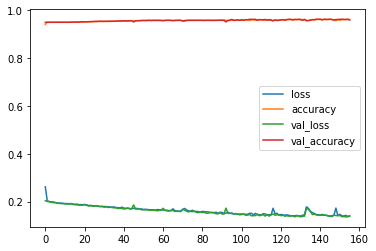

In [28]:
# Getting loss and accuracy plot
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

# Getting predictions metrics
predictions = model.predict_classes(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))